In [13]:
#https://keras.io/examples/vision/3D_image_classification/

In [2]:
import os #conda activate tf2
import numpy as np
import pandas as pd
import shutil,os,glob

from nibabel.testing import data_path
import nibabel as nib
from intensity_normalization.typing import Modality, TissueType
from intensity_normalization.normalize.fcm import FCMNormalize
from scipy.ndimage import gaussian_filter
from scipy import ndimage
import tensorflow as tf
from tensorflow import *

In [2]:
pwd

'D:\\brains'

In [3]:
parent_dir='D:\\brains'

In [4]:
df=pd.read_excel('Classification_clean.xlsx')
df.shape

(674, 15)

In [5]:
df.isnull().sum(axis=0).sort_values(ascending=False).head()

ID_CF                                    0
FirstEpisodes_FEP__HealthyControl_HC_    0
FEP_binary                               0
Diagnosis                                0
Gender                                   0
dtype: int64

In [6]:
len(df['ID_CF'].unique())

674

In [7]:
df['Diagnosis'].value_counts()

0    451
1     74
4     52
7     35
5     25
3     18
2     17
6      2
Name: Diagnosis, dtype: int64

In [8]:
df['Target']=df['Diagnosis']>0

In [9]:
df.Target.value_counts()

False    451
True     223
Name: Target, dtype: int64

In [12]:
#https://github.com/jcreinhold/intensity-normalization/blob/master/tutorials/5min_tutorial.rst

In [19]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [277]:
df[['ID_CF','Target']].head(10)

,ID_CF,Target
0,CF_001,True
1,CF_002,True
2,CF_003,True
3,CF_004,True
4,CF_005,True
5,CF_007,True
6,CF_008,True
7,CF_009,True
8,CF_010,True
9,CF_011,True


In [3]:
dir1='D:\\brains\\Target_normal'
dir2='D:\\brains\\Target_abnormal'

In [284]:
n=0
tmp1=[]
index=0
print('Total images:',len(glob.glob('*.gz')))
for i in glob.glob('*.gz'): 
    pos1=i.find('CF')
    pos2=pos1+6
    pos3=i.find('CF')
    pos4=pos3+6
    
    if i[pos3:pos4] in list(df['ID_CF'].values):
        if df[df.loc[:,'ID_CF']==i[pos3:pos4]].Target.values[0]==True:
            shutil.copyfile(parent_dir+'\\'+i, os.path.join(parent_dir, dir1+'\\'+i))
            
        else:
            shutil.copyfile(parent_dir+'\\'+i, os.path.join(parent_dir, dir2+'\\'+i))

print('Total number of normal images in directory:',len(os.listdir(dir1)))
print('Total number of abnormal images in directory:',len(os.listdir(dir2)))

Total images: 761
Total number of normal images in directory: 225
Total number of abnormal images in directory: 453


In [330]:
a=[] #files to be removed from folder
for i in os.listdir(dir2):
    i=i[1:7]
    if i not in a:
        a.append(i)
    else:
        print(i)

CF_383
CF_645


In [331]:
b=[]#files to be removed from folder
for i in os.listdir(dir1):
    i=i[1:7]
    if i not in a:
        a.append(i)
    else:
        print(i)

CF_063
CF_610


In [190]:
df['Target'].value_counts()

False    451
True     223
Name: Target, dtype: int64

preprocessing 
- zscore normalisation
- gaussian filtering
- data augmentation

In [21]:
normal_mri_scans_pth=[os.path.join(os.getcwd(),dir1,i) for i in os.listdir(dir1)]
abnormal_mri_scans_pth=[os.path.join(os.getcwd(),dir2,i) for i in os.listdir(dir2)]

In [22]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_mri_scans_pth])
normal_scans = np.array([process_scan(path) for path in normal_mri_scans_pth])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

In [24]:
abnormal_scans.shape

(451, 128, 128, 64)

 data augmentation

create neural network

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
mri_file ='wCF_001_MRI_sMRI_CF_001_brain.nii.gz'
img = nib.load(mri_file)

In [5]:
type(img)

nibabel.nifti1.Nifti1Image

In [6]:
img.shape# 3D (anatomical) scan
#79 voxels in first dim 95 voxels in the second dimension, and 79 voxels in the third dimension.

(79, 95, 79)

In [7]:
print(img.header.get_zooms())
print(img.header.get_xyzt_units())

(2.0, 2.0, 2.0)
('mm', 'sec')


In [8]:
img_data=img.get_fdata()

In [9]:
sampel_cut=img_data[:50,:50:50]
img_data[30,:,:].shape

(95, 79)

In [1]:
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"#matplotlib error kernel dies when using pyplot

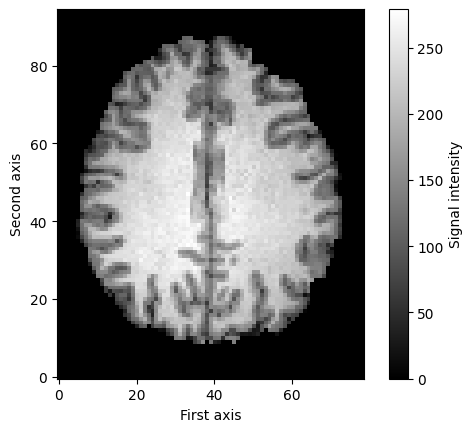

In [17]:
plt.imshow(img_data[:,:,50].T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

In [13]:
img_data.shape

(79, 95, 79)

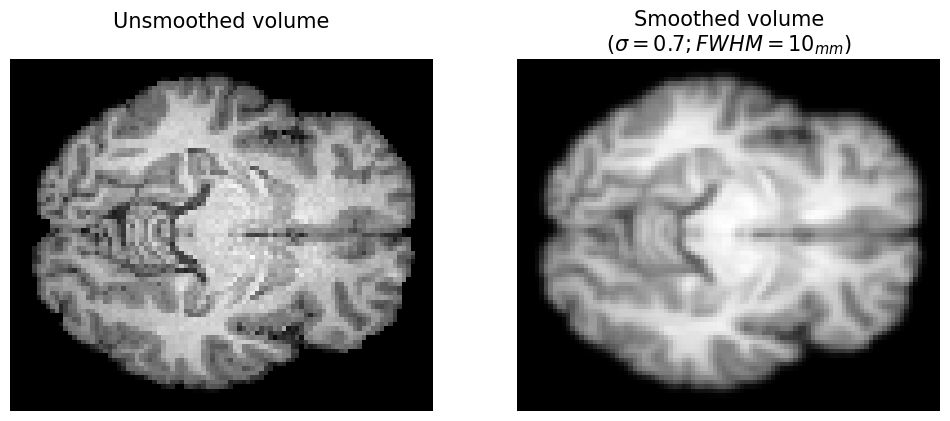

In [21]:
fwhm = 10
voxelsize = 6

sigma = fwhm / (np.sqrt(8 * np.log(2)) * voxelsize)
smoothed_vol = gaussian_filter(img_data, sigma=sigma)

# Let's plot both the unsmoothed and smoothed volume
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_data[:, :, 30], cmap='gray') # And we'll pick the 11th axial slice to visualize
plt.axis('off')
plt.title("Unsmoothed volume\n", fontsize=15)

plt.subplot(1, 2, 2)
plt.imshow(smoothed_vol[:, :, 30], cmap='gray')
plt.axis('off')
plt.title('Smoothed volume\n($\sigma = %.1f; FWHM = %s_{mm}$)' % (sigma, fwhm), fontsize=15)
plt.show()

In [22]:
fcm_norm = FCMNormalize(tissue_type=TissueType.WM)
normalized = fcm_norm(img_data)

C:\Users\syeda\anaconda3\envs\tf2\lib\site-packages\intensity_normalization\normalize\base.py:89: UserWarning: Data contains negative values; skull-stripped functionality assumes the foreground is all positive. Provide the brain mask if otherwise.
  warnings.warn(msg)


In [24]:
mask = nib.load("brainmask.nii").get_fdata()

In [25]:
mask.shape

(91, 109, 91)

(-0.5, 94.5, 78.5, -0.5)

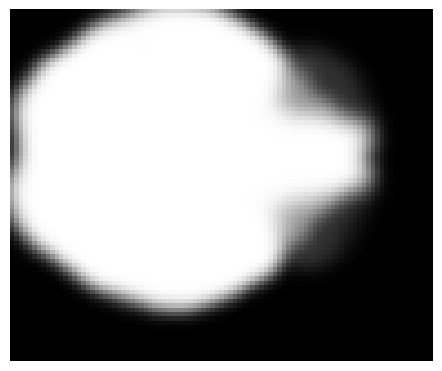

In [56]:
# Let's plot both the unsmoothed and smoothed volume
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask[12:,14:, 25], cmap='gray') # And we'll pick the 11th axial slice to visualize
plt.axis('off')

In [57]:
mask[12:, 14:, 50].shape

(79, 95)

In [58]:
img_data.shape

(79, 95, 79)

In [59]:
img_data[:, :, 30].shape

(79, 95)

In [64]:
normalized_t1w = fcm_norm(img_data[:, :, 30],mask[12:,14:, 25])
# the WM mask is an attribute in the class, so normalize the t2 with:
normalized_t2w = fcm_norm(normalized, modality=Modality.T2)

TypeError: Axis must be specified when shapes of a and weights differ.

In [80]:
from intensity_normalization.normalize.zscore import ZScoreNormalize

In [83]:
from intensity_normalization.normalize.nyul import NyulNormalize

In [84]:
new_nyul_normalizer = NyulNormalize()